<a href="https://colab.research.google.com/github/SDP1122/StockPredictor/blob/main/mva_algotrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Description - this program uses the 3 moving average cross-over strategy to 
# determine when to buy and sell a stock 
# 3 MVAs are: short/fast mva, medium mva, long/slow mva
# Two sets of buy/sell strategies based on 3 MVAs
#buy - mid crosses above the slow && short crosses above mid
#sell - short cross below mid

#buy - mid crosses below the slow  && short crosses below mid
#sell - short crosses above mid

In [103]:
!pip install --upgrade pandas-datareader 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [104]:
#Import the libs
import pandas_datareader as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [105]:
#Load the dataset
start_date = '2019-10-01'
end_date = '2020-12-31'
df = web.DataReader('TSLA', data_source='yahoo', start=start_date, end=end_date)


In [106]:
df.head()
#df.index[0]


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-10-01,49.189999,47.826000,48.299999,48.938000,30813000.0,48.938000
2019-10-02,48.930000,47.886002,48.658001,48.625999,28157000.0,48.625999
2019-10-03,46.896000,44.855999,46.372002,46.605999,75422500.0,46.605999
2019-10-04,46.956001,45.613998,46.321999,46.285999,39975000.0,46.285999
2019-10-07,47.712002,45.709999,45.959999,47.543999,40321000.0,47.543999


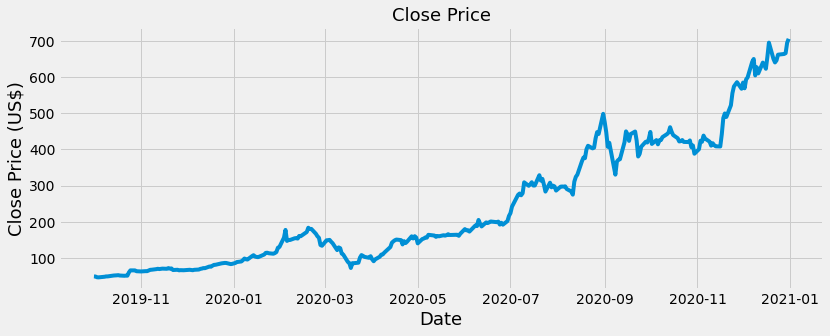

In [107]:
#Show the close price
plt.figure(figsize=(12.2,4.5))
plt.title('Close Price', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (US$)', fontsize=18)
plt.plot(df['Close'])
plt.show()

In [108]:
#Calculate the 3 exponential moving avergaes
#Short/Fast EMA
shortEMA = df['Close'].ewm(span=5, adjust=False).mean()
#Middle/Medium EMA
middleEMA = df['Close'].ewm(span=21, adjust=False).mean()
#Long/Slow EMA
longEMA = df['Close'].ewm(span=63, adjust=False).mean()

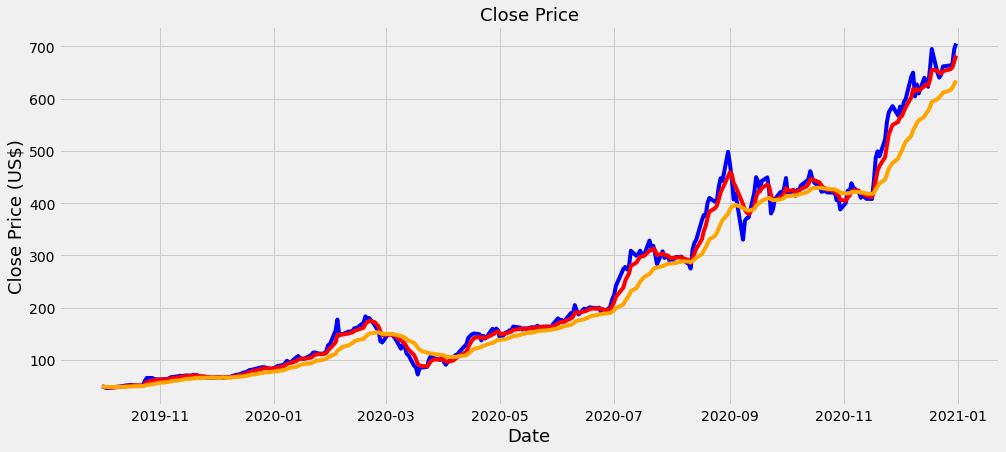

In [109]:
#Visualize closing price and EMAs
#plt.figure(figsize=(12.2,4.5))
plt.figure(figsize=(15.0,6.5))
plt.title('Close Price', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (US$)', fontsize=18)
plt.plot(df['Close'], color='blue')
plt.plot(shortEMA, label='short/fast EMA', color='red')
plt.plot(middleEMA, label='middle/Medium EMA', color='orange')
#plt.plot(longEMA, label='long/slow EMA', color='green')       #Just going to use 2 EMA signals - short & medium
plt.show()

In [110]:
#Add EMAs to the dataset
df['Short'] = shortEMA
df['Middle'] = middleEMA
#df['Long'] = longEMA #will use only 2 EMA signals - short and medium
#df.head()

In [111]:
#Create function to buy and sell the stock
def buy_sell_func(data):

  buy_list = []
  sell_list = []
  flag_long = False
  flag_short = False

  for i in range(0, len(data)):
    if data['Middle'][i] < data['Long'][i] and data['Short'][i] < data['Middle'][i] and flag_long == False and flag_short == False: 
      buy_list.append(data['Close'][i])
      sell_list.append(np.nan)
      flag_short = True
    elif flag_short == True and data['Short'][i] > data['Middle'][i]:
      sell_list.append(data['Close'][i])
      buy_list.append(np.nan)
      flag_short = False
    elif data['Middle'][i] > data['Long'][i] and data['Short'][i] > data['Middle'][i] and flag_long == False and flag_short == False: 
      buy_list.append(data['Close'][i])
      sell_list.append(np.nan)
      flag_long = True
    elif flag_long == True and data['Short'][i] < data['Middle'][i]:
      sell_list.append(data['Close'][i])
      buy_list.append(np.nan)
      flag_long = False
    else:
      buy_list.append(np.nan)
      sell_list.append(np.nan)

  return (buy_list, sell_list)


In [129]:
#Alternative "simpler" function to buy sell at crossovers of 2 EMA signals - short & medium
def buy_sell_simple(data):
  buy_list = []
  sell_list = []
  unit_pl = 0 #for profit loss calculation
  flag_buy = False
  flag_sell = False

  for i in range(0,len(data)):
    if data['Short'][i] > data['Middle'][i] and flag_buy == False:
      buy_list.append(data['Close'][i])
      sell_list.append(np.nan)
      unit_pl -= data['Close'][i] #paid close price by buying
      #testing
      #print("PAID {:.2f} to buy on {}, current p&l = {:.2f}".format(data['Close'][i], data.index[i], unit_pl))
      #print()
      flag_buy = True 
      flag_sell = False 
    elif data['Short'][i] < data['Middle'][i] and flag_sell == False:
      sell_list.append(data['Close'][i])
      buy_list.append(np.nan)
      unit_pl += data['Close'][i] #earned close price by selling
      #testing
      #print("EARNED {:.2f} to sell on {}, current p&l = {:.2f}".format(data['Close'][i], data.index[i], unit_pl))
      #print()
      flag_sell = True
      flag_buy = False
    else:
      buy_list.append(np.nan)
      sell_list.append(np.nan)
  
  #edit
  print("unit_pl = {:.2f} & last closiing price = {:.2f} ".format(unit_pl,data['Close'][len(data)-1]))
  unit_pl += data['Close'][len(data)-1] #add the last closing price of the data set 
  
  return (buy_list, sell_list, unit_pl)


In [130]:
#Add buy and sell signals to the data set
#df['Buy'] = buy_sell_func(df)[0]
#df['Sell'] = buy_sell_func(df)[1]

#Using simple buy-sell strategy using 2 EMAS
df['Buy'], df['Sell'], total_pl = buy_sell_simple(df)

#df['Buy'] = buy_sell_simple(df)[0]
#df['Sell'] = buy_sell_simple(df)[1]
#total_pl = buy_sell_simple(df)[2]


unit_pl = -120.08 & last closiing price = 705.67 


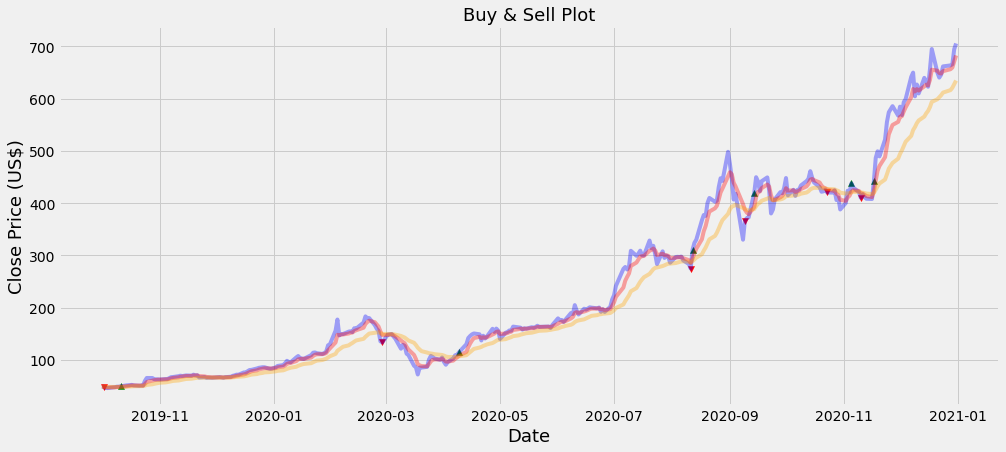

In [131]:
#Visually show the buy and sell signals
plt.figure(figsize=(15,6.5))
plt.title('Buy & Sell Plot', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (US$)', fontsize=18)
plt.plot(df['Close'], color='blue', alpha=0.35)
plt.plot(shortEMA, label='short/fast EMA', color='red', alpha=0.35)
plt.plot(middleEMA, label='middle/Medium EMA', color='orange', alpha=0.35)
#plt.plot(longEMA, label='long/slow EMA', color='green', alpha=0.35)       #Using only 2 EMA signals - short & medium
plt.scatter(df.index, df['Buy'], color = 'green', marker = '^', alpha=1)
plt.scatter(df.index, df['Sell'], color = 'red', marker = 'v', alpha=1)
plt.show()

In [132]:
#Show the total P&L from all buy and sell trades
print(f"total P&L from all buys and sells = {total_pl:.2f} US$")

total P&L from all buys and sells = 585.59 US$
